# get sample data 

In [1]:
import discogs_client
# authenticate to DISCOGS.COM
token = 'FBvXNlFYwMjpXpOkCBYtlyNdawVggJqXcQZJLoJC'
discogs = discogs_client.Client('myApp',  user_token= token)

In [2]:
# name, year, first release discogs id
albums = [
    ["From Her To Eternity", 1984, 399486],
    ["The Firstborn Is Dead", 1985, 407865],
    ["Your Funeral ... My Trial", 1986, 4705533],
    ["Kicking Against The Pricks", 1986, 431654],
    ["Tender Prey", 1988, 325250],
    ["The Good Son", 1990, 412390],
    ["Henry's Dream", 1992, 386584],
    ["Let Love In", 1994, 6539255],
    ["Murder Ballads", 1996, 370564],
    ["The Boatman's Call", 1997, 370607],
    ["No More Shall We Part", 2001, 424340],
    ["Nocturama", 2002, 380437],
    ["Abattoir Blues / The Lyre Of Orpheus", 2004, 379708],
    ["Dig, Lazarus, Dig!!!", 2008, 1268853],
    ["Push The Sky Away", 2012, 4262582],
    ["Skeleton Tree", 2016, 8989572],
    ["Ghosteen", 2019, 14179590],
]

In [3]:
import pandas as pd
import time

In [4]:
def get_tracklists(albums_list):
    # empty dataframe
    albums_info = pd.DataFrame()
    # empty list for each final column
    col_year, col_album, col_track_position, col_track_title = [], [], [], []
    # for every album
    for album in albums_list:
        # get the relase
        release = discogs.release(album[2])
        # get the release's master
        release_master = release.master
        # get master tracklist
        tracklist = release_master.tracklist
        # wait - too fast will disconnect the API
        time.sleep(2)
        # for each track populate the columns
        for track in tracklist:
            col_year.append(album[1])
            col_album.append(album[0])
            col_track_position.append(track.position)
            col_track_title.append(track.title)
    # populate the dataframe
    albums_info['year'] = col_year
    albums_info['album'] = col_album
    albums_info['track_position'] = col_track_position
    albums_info['track_title'] = col_track_title
    # return dataframe
    return albums_info


In [5]:
albums_info = get_tracklists(albums)

In [6]:
#cleand rows without track position - not tracks
discog = albums_info[albums_info.track_position != ''].copy()

In [7]:
discog.reset_index(inplace=True)

In [8]:
discog.drop(columns=['index'],inplace=True)


In [9]:
# overwrite track position with generated numbers instead of inconsistent source (i.e. vinyls are A1, A2, B1)
for i in range(discog.shape[0]-1):
    if i == 0 or discog.loc[i, 'album'] != discog.loc[i-1, 'album']:
        discog.loc[i, 'track_position'] = 1
    else:
        discog.loc[i, 'track_position'] = int(discog.loc[i-1, 'track_position']) + 1
#transform year into datetime datatype
discog['year'] = pd.to_datetime(discog['year'], format='%Y').dt.year

# look at sample

In [10]:
discog.head()

,year,album,track_position,track_title
0,1984,From Her To Eternity,1,Avalanche
1,1984,From Her To Eternity,2,Cabin Fever!
2,1984,From Her To Eternity,3,Well Of Misery
3,1984,From Her To Eternity,4,From Her To Eternity
4,1984,From Her To Eternity,5,Saint Huck


In [11]:
# will display a button to PRINT Discography.

In [33]:
for i, r in discog[['year', 'album']].drop_duplicates().iterrows():
    print(r['year'], r['album'])

1984 From Her To Eternity
1985 The Firstborn Is Dead
1986 Your Funeral ... My Trial
1986 Kicking Against The Pricks
1988 Tender Prey
1990 The Good Son
1992 Henry's Dream
1994 Let Love In
1996 Murder Ballads
1997 The Boatman's Call
2001 No More Shall We Part
2002 Nocturama
2004 Abattoir Blues / The Lyre Of Orpheus
2008 Dig, Lazarus, Dig!!!
2012 Push The Sky Away
2016 Skeleton Tree
2019 Ghosteen


# make plot

In [12]:
from UI import UI

# will:
# diplay a slider to choose the size of the period
# display a button to update the chart based on the selected period size


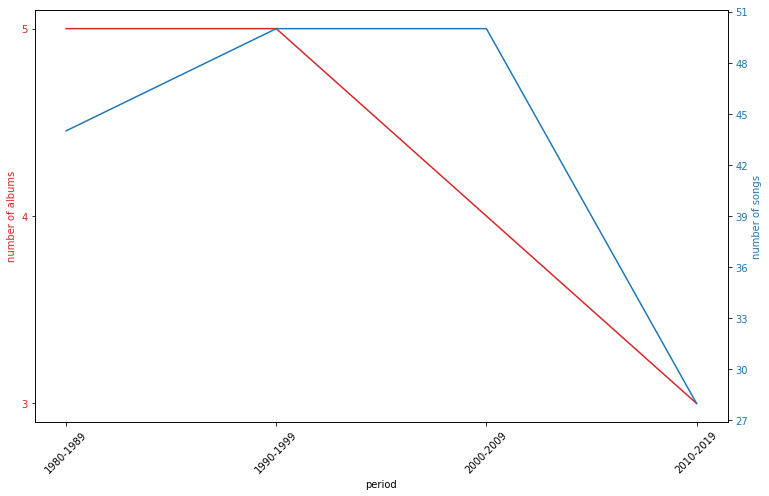

In [21]:
UI.plot_albums_songs_per_period(discog,10)